# Cross-Sectional / "Assaying Anomalies" Style Analysis

This code replicates the "Table 1" analysis in many cross sectional asset pricing papers, which is a univariate sort showing alpha returns of portfolios (determined by sorting stocks along one dimension, thus "univariate") against six different benchmarks.

The basic idea of this kind of table is that
1. We measure _something_ about stocks. Maybe it's their size, or their recent returns. Let's call this variable X.
2. Then we sort stocks on X every month and divide them into 5 or 10 buckets. The stocks in each bucket constitute a portfolio, so we get the returns for that bucket for the next month. We also compute the "Long-Short" portfolio, which is always the return of the highest bucket minus the lowest bucket. Long-short portfolio are what you would get if you short the stocks in the lowest bucket to go long the highest bucket, and are "zero cost" portfolios.
3. We repeat this across time so we can see how each portfolio/bucket does and show the average return in each bucket.
4. To be more sophisticated, we do step 3 a few ways: we look at the portfolio returns compared to the market, and we also compute the portfolio alphas against some benchmark factor models.
5. If we see significant results in the High Minus Low column, practicianers will say that X is an "anomaly", in that the asset pricing model can't explain its returns.


---

The plan for this code file comes from the ["Assaying Anomalies""](https://sites.psu.edu/assayinganomalies) project, which is a protocol to evaluate whether a given factor X is useful in predicting returns.
- Here is the [repo](https://github.com/velikov-mihail/AssayingAnomalies) containing that project's code (mostly in Matlab as of Spring 2025, but will be in Python soon).
- The paper describing that project, which you should read (its breezy), and what you should cite is: Novy-Marx, Robert and Velikov, Mihail, Assaying Anomalies (February 13, 2024). Available at SSRN: https://ssrn.com/abstract=4338007 or http://dx.doi.org/10.2139/ssrn.4338007

The other exciting resource this page is meant to tell you about is `openassetpricing`:
- https://www.openassetpricing.com/data/ is an incredible project for anyone interested in asset pricing. **It makes it possible for any student to get close to the frontier of asset pricing faster than ever!** This is because it makes it simple to get all the essential data you need. Within the site, there is lots of background info, and a companion paper.
- Downloading the data in python is easy with the `openassetpricing` package: here are [the docs](https://github.com/mk0417/open-asset-pricing-download) (amazinnnng) and its [examples](https://github.com/mk0417/open-asset-pricing-download/tree/master/examples) include
  - [quick tour](https://github.com/mk0417/open-asset-pricing-download/blob/master/examples/quick_tour.ipynb)
  - [plot one anomaly](https://github.com/mk0417/open-asset-pricing-download/blob/master/examples/anomaly_plot.ipynb)
  - [ML_portfolio_example](https://github.com/mk0417/open-asset-pricing-download/blob/master/examples/ML_portfolio_example.ipynb)  (amazinnnng)
  - [merge_portfolios_with_ff_factors](https://github.com/mk0417/open-asset-pricing-download/blob/master/examples/merge_portfolios_with_ff_factors.ipynb)
- https://github.com/OpenSourceAP/CrossSectionDemos (in R)


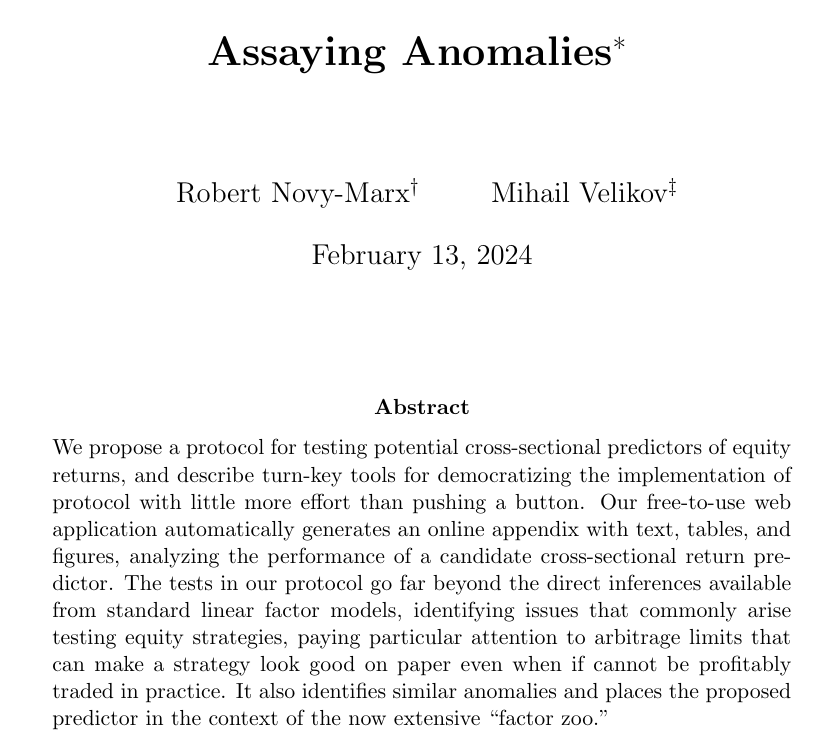

In our code below, we are trying to replicate the structure of this table below, from Novy-Marx and Velikov.

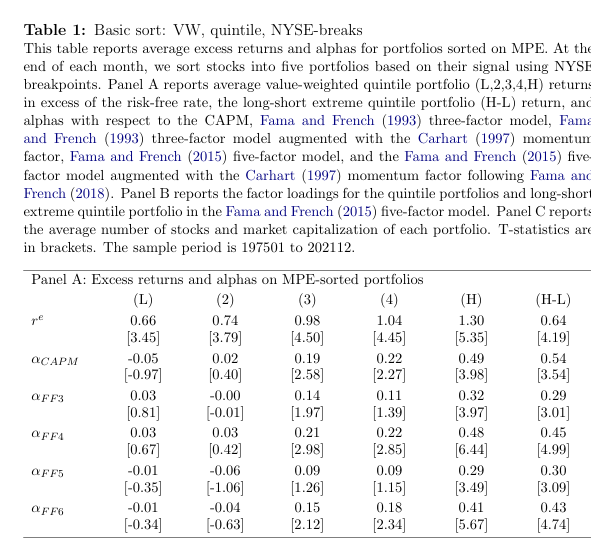

In [ ]:
# !pip install pandas-datareader # run this once, then comment

import pandas_datareader.famafrench as ff
import pandas as pd
import numpy as np
import statsmodels.api as sm
import statsmodels.formula.api as smf
import warnings
warnings.simplefilter(action="ignore", category=FutureWarning)

# datasets = ff.get_available_datasets()
# datasets


## Step 1: Get the factor portfolio returns.

In [ ]:
# I think this are in the opensourceAP dataset, and you should grab from that source instead, IMO
df_factors = ff.FamaFrenchReader('F-F_Research_Data_5_Factors_2x3', start='1900-01-01').read()[0]

# add momentum to this
mom = ff.FamaFrenchReader('F-F_Momentum_Factor', start='1900-01-01').read()[0] # add momentum
mom.columns = ['Mom'] # rename
df_factors = pd.merge(df_factors, mom, left_index=True, right_index=True)
df_factors # FYI: contains Mkt-RF and RF, but no Mkt


,Mkt-RF,SMB,HML,RMW,CMA,RF,Mom
Date,,,,,,,
1963-07,-0.39,-0.41,-0.97,0.68,-1.18,0.27,0.90
1963-08,5.07,-0.80,1.80,0.36,-0.35,0.25,1.01
1963-09,-1.57,-0.52,0.13,-0.71,0.29,0.27,0.19
1963-10,2.53,-1.39,-0.10,2.80,-2.01,0.29,3.12
1963-11,-0.85,-0.88,1.75,-0.51,2.24,0.27,-0.74
...,...,...,...,...,...,...,...
2024-08,1.61,-3.65,-1.13,0.85,0.86,0.48,4.79
2024-09,1.74,-1.02,-2.59,0.04,-0.26,0.40,-0.60
2024-10,-0.97,-0.88,0.89,-1.38,1.03,0.39,2.87


## Step 2: Get your signal, then construct portfolio returns.

**Note: I'm just picking easily available portfolios. Your work is here.**

Upgrade: Make everything from here to the table a function. (So you can do decile or tercile splits, or change how splits are done, in one line of code.)

In [ ]:
# now, here we'd develop some "signal" and then create portfolio rets based on it
# I'm skipping... you figure that out

# I'll pretend I did that by grabbing 5 industry portfolio returns
df_portfolios = ff.FamaFrenchReader('5_Industry_Portfolios', start='1900-01-01').read()[0]
df_portfolios.columns = [f'Port{i+1}' for i in range(len(df_portfolios.columns))] # this is my anticipated portfolio number name scheme

df_portfolios.eval("HmL = Port5-Port1", inplace=True)

# Make each portfolio (except for HmL) excess returns
for col in ['Port1', 'Port2', 'Port3', 'Port4', 'Port5']:
    df_portfolios[col] = df_portfolios[col] - df_factors['RF']

portfolios = df_portfolios.columns.tolist()

df_portfolios



## Step 3: Run the regressions.

In [ ]:
reg_df = pd.merge(df_factors, df_portfolios, left_index=True, right_index=True)
reg_df

,Mkt-RF,SMB,HML,RMW,CMA,RF,Mom,Port1,Port2,Port3,Port4,Port5,HmL
Date,,,,,,,,,,,,,
1975-01,13.66,12.91,8.28,-0.78,-0.90,0.58,-13.82,21.19,11.94,12.90,-1.32,17.31,-3.88
1975-02,5.56,-0.65,-4.45,1.16,-2.11,0.43,-0.61,4.23,4.63,9.34,15.61,2.44,-1.79
1975-03,2.66,4.00,2.38,1.26,-1.33,0.41,-2.04,7.75,1.40,-0.17,0.88,3.74,-4.01
1975-04,4.23,-0.71,-1.14,1.41,-1.34,0.44,1.38,2.75,6.82,2.53,0.21,2.83,0.08
1975-05,5.19,2.89,-4.10,-0.98,-0.60,0.44,-0.58,3.60,5.95,4.56,6.08,5.28,1.68
...,...,...,...,...,...,...,...,...,...,...,...,...,...
2024-08,1.61,-3.65,-1.13,0.85,0.86,0.48,4.79,0.57,0.70,0.86,5.96,2.55,1.98
2024-09,1.74,-1.02,-2.59,0.04,-0.26,0.40,-0.60,4.01,1.54,2.69,-2.21,0.26,-3.75
2024-10,-0.97,-0.88,0.89,-1.38,1.03,0.39,2.87,-2.08,-2.38,-0.48,-3.50,0.72,2.80


In [ ]:
# define factor model formulas (these are the right side of the regrssion formulas)
# these are how formulas are specified for statsmodel's formula api
factor_models = {
    'r^e':  '1',
    'CAPM': 'Q("Mkt-RF")',
    'FF3':  'Q("Mkt-RF") + SMB + HML',
    'FF4':  'Q("Mkt-RF") + SMB + HML + Mom',
    'FF5':  'Q("Mkt-RF") + SMB + HML + RMW + CMA',
    'FF6':  'Q("Mkt-RF") + SMB + HML + RMW + CMA + Mom'
}

In [ ]:
# pre built output table

index = pd.MultiIndex.from_product([factor_models.keys(), ['alpha', 't-stat']], names=['Model', 'Metric'])
results = pd.DataFrame(index=index, columns=portfolios, dtype=float)
results

Port1  Port2  Port3  Port4  Port5  HmL
Model Metric                                        
r^e   alpha     NaN    NaN    NaN    NaN    NaN  NaN
      t-stat    NaN    NaN    NaN    NaN    NaN  NaN
CAPM  alpha     NaN    NaN    NaN    NaN    NaN  NaN
      t-stat    NaN    NaN    NaN    NaN    NaN  NaN
FF3   alpha     NaN    NaN    NaN    NaN    NaN  NaN
      t-stat    NaN    NaN    NaN    NaN    NaN  NaN
FF4   alpha     NaN    NaN    NaN    NaN    NaN  NaN
      t-stat    NaN    NaN    NaN    NaN    NaN  NaN
FF5   alpha     NaN    NaN    NaN    NaN    NaN  NaN
      t-stat    NaN    NaN    NaN    NaN    NaN  NaN
FF6   alpha     NaN    NaN    NaN    NaN    NaN  NaN
      t-stat    NaN    NaN    NaN    NaN    NaN  NaN

In [ ]:
# Run regressions for each portfolio and model

full_reg_outout = {} # to save everything, in case we want to access other stuff (like beta loadings)
for portfolio in portfolios:
    for model_name, formula in factor_models.items():
        reg = smf.ols(formula=f'{portfolio} ~ {formula}', data=reg_df).fit()
        # extract the intercept coef and t-stat
        alpha = reg.params['Intercept']
        t_stat = reg.tvalues['Intercept']
        results.at[(model_name, 'alpha'), portfolio] = alpha
        results.at[(model_name, 't-stat'), portfolio] = t_stat
        full_reg_outout[(model_name, portfolio)] = reg

results

Port1     Port2     Port3     Port4     Port5       HmL
Model Metric                                                            
r^e   alpha   0.661057  0.557900  0.646938  0.681369  0.597724 -0.063333
      t-stat  3.900987  3.433497  3.230902  3.859817  3.052126 -0.647961
CAPM  alpha   0.114768  0.038745  0.010464  0.203102 -0.043658 -0.158426
      t-stat  1.630695  0.550711  0.118044  1.773375 -0.584753 -1.670608
FF3   alpha   0.091171 -0.052544  0.137807  0.302106 -0.186326 -0.277498
      t-stat  1.290888 -0.815539  1.721098  2.730282 -3.023698 -3.132967
FF4   alpha   0.124516 -0.093283  0.208553  0.235236 -0.152898 -0.277413
      t-stat  1.733414 -1.427806  2.585315  2.095277 -2.442501 -3.067951
FF5   alpha  -0.074883 -0.184758  0.318594  0.133618 -0.180963 -0.106080
      t-stat -1.142738 -2.948850  4.167975  1.209001 -2.945735 -1.222041
FF6   alpha  -0.032642 -0.206952  0.362788  0.093130 -0.155887 -0.123244
      t-stat -0.496089 -3.265914  4.717103  0.833356 -2.511528 -1.400810